# An MMD Approach to Inferring Weak Lensing Convergence from Galaxy Sizes


## Table of Contents
1. [Imports & Data Loading](#section1)
2. [Helper Functions](#section2)
3. [Analysis of the Pixel Mean](#section3)
4. [Finer Convergence Map](#section4)
5. [Creating an Estimator](#section5)
6. [Recovery of the Convergence Map and Power Spectrum](#section6)
7. [Recovery of new Convergence Map for Validation](#section7)


<a id='section1'></a>
## 1. Imports and Data Loading

In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import skew, kurtosis

In [2]:
# load the catalogue and power spectrum
catalogue1000 = np.load('catalogue_1000sqd.npy')
cl_kappa_225 = np.loadtxt('cl_kappa_mean_225.txt')[:,1]
cl_kappa_225 = np.concatenate((np.zeros(2), cl_kappa_225)) # add zeros for monopole and dipole

np.random.seed(79)  # for reproducibility
nside = 64 # HEALPix nside parameter
kappamap_225 = hp.synfast(cl_kappa_225, nside)  # create a kappa map from the power spectrum 
print("Cl_kappa225 shape:", cl_kappa_225.shape, "   kappamap225 shape:", kappamap_225.shape )


print( "\nrange of DEC of catalogue1000:")
print(f"[{min(catalogue1000['dec'])},{max(catalogue1000['dec'])}]" )
print( "\nrange of RA of catalogue1000:")
print(f"[{min(catalogue1000['ra'])},{max(catalogue1000['ra'])}]" )
print('-'*30)

# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix1000= hp.ang2pix(nside, catalogue1000['ra'], catalogue1000['dec'], lonlat=True) # Pixel index for each galaxy
galaxy_pix1000_unique, galaxy_pix1000_counts = np.unique(galaxy_pix1000, return_counts=True)
n_pixels = hp.nside2npix(nside)

print("Galaxy pixels:",galaxy_pix1000, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000))
print("Total number of galaxies:", len(catalogue1000))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts >= 20000))
print('-'*30)

pixscale = 0.263
intrinsic_size1000 = catalogue1000['r50'] * pixscale   #arcsec
observed_size1000 = intrinsic_size1000 * (1.0 + kappamap_225[galaxy_pix1000])

Cl_kappa225 shape: (10000,)    kappamap225 shape: (49152,)

range of DEC of catalogue1000:
[-17.89552116394043,17.89537239074707]

range of RA of catalogue1000:
[-17.928665161132812,17.927947998046875]
------------------------------
Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31574550
Total number of galaxies: 31574550
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25300.12019230769
Number of pixels with > 20'000 galaxies: 1145
------------------------------


<a id='section2'></a>
## 2. Helper functions

In [30]:
# SIMPLE IMPLEMENTATION OF MMD FOR DIFFERENT KERNELS ---------------------------------
"""The functions to compute the MMD are mostly used in python scripts that we run on the Euler Cluster"""
def compute_mmd(X, Y, kernel):
    """
    Compute Maximum Mean Discrepancy (MMD) between samples X and Y using a provided kernel.
    
    Parameters:
        X: array-like, shape (n_samples_X, n_features)
        Y: array-like, shape (n_samples_Y, n_features)
        kernel: callable, must support signature kernel(X, Y), returns kernel matrix
        
    Returns:
        mmd2: float, MMD^2 value
    """

    X = np.asarray(X)
    Y = np.asarray(Y)
    m = X.shape[0]
    n = Y.shape[0]
    
    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)
    
    # Remove diagonal for unbiased estimator
    # np.fill_diagonal(K_XX, 0)
    # np.fill_diagonal(K_YY, 0)
    
    mmd2 = (K_XX.sum() / (m * m)) \
        + (K_YY.sum() / (n * n)) \
        - (2 * K_XY.sum() / (m * n))
    
    return mmd2

def compute_mmd_subsample(X, Y, kernel, size_X=1000, size_Y=1000, n_iter=10, random_state=None):
    """
    Compute MMD between large X and Y by random subsampling.
    Parameters:
        X: array-like (N_X, features), large dataset
        Y: array-like (N_Y, features), large dataset
        kernel: callable kernel (scikit-learn compatible)
        size_X: int, subsample size from X
        size_Y: int, subsample size from Y
        n_iter: int, number of repetitions
        random_state: int or None, reproducibility
    Returns:
        avg_mmd: float, average MMD over n_iter subsamples
        mmd_values: list of individual MMD values
    """
    rng = np.random.default_rng(random_state)
    mmd_values = []
    for i in range(n_iter):
        Xs = rng.choice(X, size_X, replace=False)
        Ys = rng.choice(Y, size_Y, replace=False)
        mmd = compute_mmd(Xs, Ys, kernel)
        mmd_values.append(mmd)
    return np.mean(mmd_values)

def plot_binned_x(x,y , binning_method='lin', n_bins=24, lin_fit=True):

    if binning_method=='lin':
        bins = np.linspace(x.min(), x.max(), n_bins+1)
        title_str = 'linspace'
    elif binning_method == 'log':
        bins = np.logspace(np.log10(x.min() + 1e-8), np.log10(x.max()), n_bins + 1)
        title_str = 'logspace'
    elif binning_method == 'quantile':
        bins = np.quantile(x, np.linspace(0, 1, n_bins + 1))
        bins[0] -= 1e-12  # include min
        title_str = 'quantile'
    else:
        raise ValueError("Invalid binning method. Choose 'lin', 'log', or 'quantile'.") 
    
    idx = np.digitize(x, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)   

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    means = np.full(n_bins, np.nan)
    stds  = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    for i in range(n_bins):
        m = (idx==i)
        c = m.sum()
        counts[i] = c
        if c >=1:
            means[i] = y[m].mean()
        if c>=2:
            stds[i] = y[m].std(ddof=1)

    ses = np.where(counts>= 2, stds/np.sqrt(counts), np.nan)

    # keep only well-populated bins
    min_count = 5
    mask = (counts >= min_count) & np.isfinite(means)
    xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

    # plt.figure()
    if lin_fit:
        # (optional) weighted fit (weights = 1/SE^2)
        w = np.where(np.isfinite(sec) & (sec>0), 1.0/sec**2, 1.0)
        fit_params, cov = np.polyfit(xc,yc, 1, w=w, cov=True)
        slope, intercept = fit_params[0], fit_params[1]
        print(f"MMD² ≈ {slope:.3e} * κ² + {intercept:.3e}")
        plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='Weighted Fit')

    plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
    plt.legend()
    # plt.show()
    return  xc, yc, sec, fit_params, cov

def binning_and_plotting(x,y, n_bins = 24, Title: str = None, plot=True):
    bins = np.linspace(x.min(), x.max(), n_bins + 1)

    # bin indices in [0, n_bins-1]
    idx = np.digitize(x, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)
    bin_centers = 0.5*(bins[1:] + bins[:-1])

    means = np.full(n_bins, np.nan)
    stds  = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    for i in range(n_bins):
        m = (idx == i)
        c = m.sum()
        counts[i] = c
        # print(f"Bin {i}: count = {c}")
        if c >= 1:
            means[i] = y[m].mean()
        if c >= 2:
            stds[i] = y[m].std(ddof=1)


    # keep only well-populated bins
    min_count = 5
    mask = counts >= min_count

    ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)
    xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

    # (optional) weighted fit (weights ~ 1/SE^2)
    w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
    fit_params, cov = np.polyfit(xc, yc, 1, w=w, cov=True)
    print(f"MMD ≈ {fit_params[0]:.3e} * κ + {fit_params[1]:.3e}")
    if not plot:
        return xc, yc, sec, fit_params
    else:
        # plt.figure()
        plt.plot(x,y, '.', label=r'MMD$^2$ per Pixel', alpha=0.2)
        plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
        # plt.plot(bin_centers, fit_params[0]*bin_centers + fit_params[1], 'r--', label='fit')
        # plt.xlabel(r'$\kappa$'); plt.ylabel(r'$\mathrm{MMD}$ (RBF kernel)')
        plt.title(Title if not Title is None else ' ')
        
        # plt.legend(); plt.show()

    return  xc, yc, sec, fit_params, cov

def plot_pixel_level_results(kappa_true, kappa_pred):
    """Generate all pixel-level validation figures"""
    
    mask = ~(np.isnan(kappa_true) | np.isnan(kappa_pred))
    kt, kp = np.asarray(kappa_true)[mask], np.asarray(kappa_pred)[mask]
    residuals = kp - kt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Pixel-Level Results (Dir. RBF)', fontsize=16)
    # 1. Scatter plot
    ax1 = axes[0, 0]
    ax1.scatter(kt, kp, alpha=0.3, s=5)
    lims = [min(kt.min(), kp.min()), max(kt.max(), kp.max())]
    ax1.plot(lims, lims, 'r--', lw=2)
    ax1.set_xlabel(r'$\kappa_{\rm true}$')
    ax1.set_ylabel(r'$\kappa_{\rm pred}$')
    ax1.set_title(f'r = {np.corrcoef(kt, kp)[0,1]:.3f}')
    
    # 2. Residual histogram
    ax2 = axes[0, 1]
    ax2.hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
    x = np.linspace(residuals.min(), residuals.max(), 200)
    ax2.plot(x, stats.norm.pdf(x, np.mean(residuals), np.std(residuals)), 'r-', lw=2)
    ax2.axvline(0, color='k', linestyle='--')
    ax2.set_xlabel(r'$\kappa_{\rm pred} - \kappa_{\rm true}$')
    ax2.set_ylabel('Density')
    ax2.set_title(f'Mean = {np.mean(residuals):.2e}, Std = {np.std(residuals):.4f}')
    
    # 3. Residuals vs true kappa
    ax3 = axes[1, 0]
    ax3.scatter(kt, residuals, alpha=0.3, s=5)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_xlabel(r'$\kappa_{\rm true}$')
    ax3.set_ylabel(r'$\kappa_{\rm pred} - \kappa_{\rm true}$')
    ax3.set_title('Residuals vs true convergence')
    print("Residuals > 0:", (residuals > 0).sum(), "Residuals < 0:", (residuals < 0).sum())
    print("Residuals vs kapp correlation coeff. :", np.corrcoef(kt, residuals)[0,1])
    # 4. Summary statistics text
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    rmse = np.sqrt(np.mean(residuals**2))
    r2 = 1 - np.sum(residuals**2) / np.sum((kt - np.mean(kt))**2)
    nrmse = rmse / np.std(kt)
    
    stats_text = f"""
    Pixel-Level Summary Statistics
    {'='*35}
    
    N pixels:           {len(kt)}
    
    Pearson r:          {np.corrcoef(kt, kp)[0,1]:.4f}
    R²:                 {r2:.4f}
    
    RMSE:               {rmse:.6f}
    NRMSE (σ):          {nrmse:.4f}
    
    Mean residual:      {np.mean(residuals):.2e}
    Std residual:       {np.std(residuals):.6f}
    """
    ax4.text(0.1, 0.5, stats_text, fontsize=14, family='monospace',
             verticalalignment='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    return ax1

def plot_residual_map(kappa_true, kappa_pred, galaxy_pix_unique, nside=64, 
                      save_path='residual_map.pdf'):
    """
    Create a HEALPix map showing spatial distribution of residuals.
    
    Parameters:
        kappa_true: array of true convergence values per pixel
        kappa_pred: array of predicted convergence values per pixel
        galaxy_pix_unique: array of pixel indices corresponding to kappa values
        nside: HEALPix nside parameter
        save_path: path to save the figure
    """
    
    # Compute residuals
    residuals = kappa_pred - kappa_true
    
    # Create empty HEALPix map (filled with NaN for empty pixels)
    npix = hp.nside2npix(nside)
    residual_map = np.full(npix, np.nan)
    
    # Fill in the residuals for pixels with data
    residual_map[galaxy_pix_unique] = residuals
    
    # Find the center of your observed patch
    # Get RA, Dec of pixels with data
    theta, phi = hp.pix2ang(nside, galaxy_pix_unique)
    ra = np.degrees(phi)
    dec = 90 - np.degrees(theta)
    
    # Center coordinates (mean of your data)
    ra_center = np.mean(ra)
    dec_center = np.mean(dec)
    
    # Determine color scale limits (symmetric around zero)
    vmax = np.nanmax(np.abs(residuals))
    vmin = -vmax
    
    # Create the plot - use cartview for rectangular projection
    fig = plt.figure(figsize=(12, 8))
    
    hp.cartview(residual_map, 
                title=r'Residual Map: $\kappa_{\rm pred} - \kappa_{\rm true}$',
                cmap='RdBu_r',
                min=vmin,
                max=vmax,
                lonra=[ra_center - 20, ra_center + 20],  # ±20 degrees
                latra=[dec_center - 20, dec_center + 20],
                cbar=True,
                unit=r'$\Delta\kappa$',
                hold=True)
    
    # hp.graticule()
    
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Residual map saved to {save_path}")
    
    return fig, residual_map

def plot_kappa_comparison_maps(kappa_true, kappa_pred, galaxy_pix_unique, 
                               nside=64, save_path='kappa_comparison.pdf'):
    """
    Create three side-by-side HEALPix maps: true, predicted, and residuals.
    """
    
    npix = hp.nside2npix(nside)
    
    # Create maps
    true_map = np.full(npix, np.nan)
    pred_map = np.full(npix, np.nan)
    residual_map = np.full(npix, np.nan)
    
    true_map[galaxy_pix_unique] = kappa_true
    pred_map[galaxy_pix_unique] = kappa_pred
    residual_map[galaxy_pix_unique] = kappa_pred - kappa_true
    
    # Find center of observed patch
    theta, phi = hp.pix2ang(nside, galaxy_pix_unique)
    ra = np.degrees(phi)
    dec = 90 - np.degrees(theta)
    ra_center = 0 #np.mean(ra)
    dec_center = 0 #np.mean(dec)
    
    # Determine color scales
    vmax_kappa = np.abs(kappa_true).max()       #max(np.nanmax(np.abs(kappa_true)), np.nanmax(np.abs(kappa_pred)))
    vmin_kappa = -vmax_kappa
    
    vmax_res =  np.nanmax(np.abs(kappa_pred - kappa_true))
    vmin_res = -vmax_res
    
    fig = plt.figure(figsize=(18, 5))
    # True convergence
    plt.subplot(131)
    hp.cartview(true_map, 
                # title=r'$\kappa_{\rm true}$',
                cmap='RdBu_r',
                min=vmin_kappa,
                max=vmax_kappa,
                lonra=[-20, 20],
                latra=[-20, 20],
                hold=True,
                sub=131)
    plt.title(r'$\kappa_{\rm true}$', fontsize=24)
    # hp.graticule()
    
    # Predicted convergence
    plt.subplot(132)
    hp.cartview(pred_map, 
                # title=r'$\kappa_{\rm pred}$',
                cmap='RdBu_r',
                min=vmin_kappa,
                max=vmax_kappa,
                lonra=[ra_center - 20, ra_center + 20],
                latra=[dec_center - 20, dec_center + 20],
                hold=True,
                sub=132)
    plt.title(r'$\kappa_{\rm pred}$', fontsize=24)
    # hp.graticule()
    
    # Residuals
    plt.subplot(133)
    hp.cartview(residual_map, 
                # title=r'$\kappa_{\rm pred} - \kappa_{\rm true}$',
                cmap='RdBu_r',
                min=vmin_res,
                max=vmax_res,
                lonra=[ra_center - 20, ra_center + 20],
                latra=[dec_center - 20, dec_center + 20],
                hold=True,
                sub=133)
    plt.title(r'$\kappa_{\rm pred} - \kappa_{\rm true}$', fontsize=24)
    # hp.graticule()
    
    # plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Comparison map saved to {save_path}")
    
    return #fig

def compute_gaussian_stats(kappa_field):
    """Compute mean, std, skewness, kurtosis of the kappa field."""
    
    mean = np.nanmean(kappa_field)
    std = np.nanstd(kappa_field)
    skewness = skew(kappa_field, nan_policy='omit')
    kurt = kurtosis(kappa_field, nan_policy='omit')
    print(f"MEAN = {mean:.4e}", f"\nSTD = {std:.4e}", f"\nSkewness = {skewness:.4e}", f"\nKurtosis = {kurt:.4e}")
    print("-"*20)
    return mean, std, skewness, kurt

<a id='section3'></a>
## 3. Analysis of the Pixel Mean

This section is a sanity check to see if we actually get a signal. We want to confirm results from previous work. It is not included in the report.


Thresholds/Constraints found in previous work:
- 20'000 galaxies per pixel for nside=64
- nside=64: In this case, the avg number of galaxies is above the needed threshold
- Outliers/Size threshold for too large galaxies: 5arcsec

In [21]:
# Apply intrinsic size mask 
size_mask = (intrinsic_size1000 < 5.0) #arcsec

galaxy_pix1000_masked = galaxy_pix1000[size_mask]
intrinsic_size1000_masked = intrinsic_size1000[size_mask]
observed_size1000_masked = intrinsic_size1000_masked*(1.0 + kappamap_225[galaxy_pix1000_masked])
galaxy_pix1000_unique_masked, galaxy_pix1000_counts_masked = np.unique(galaxy_pix1000_masked, return_counts=True)

print("Summary after applying size cut of 5 arcsec:")
print("Galaxy pixels:",galaxy_pix1000_masked, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000_masked))
print("Total number of galaxies:", len(intrinsic_size1000_masked))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique_masked))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts_masked))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts_masked))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts_masked))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts_masked >= 20000))
print('-'*30)

Summary after applying size cut of 5 arcsec:
Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31571431
Total number of galaxies: 31571431
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25297.620993589742
Number of pixels with > 20'000 galaxies: 1145
------------------------------


In [23]:
# Computing the mean before and after lensing
means_unlensed = []
means_lensed = []
pixels = []


for p in galaxy_pix1000_unique_masked:
    mask = (galaxy_pix1000_masked == p)
    if sum(mask) > 20000:   # Only consider pixels with more than 20'000 galaxies
        means_unlensed.append(np.mean(intrinsic_size1000_masked[mask]))
        means_lensed.append(np.mean(observed_size1000_masked[mask]))
        pixels.append(p)

means_unlensed = np.array(means_unlensed)
means_lensed = np.array(means_lensed)
# np.save("means_unlensed_1000sqd.npy", means_unlensed)
# np.save("means_lensed_1000sqd.npy", means_lensed)
# np.save("pixels_1000sqd.npy", np.array(pixels))

# means_lensed = np.load("means_lensed_1000sqd.npy")
# means_unlensed = np.load("means_unlensed_1000sqd.npy")
# pixels = np.load("pixels_1000sqd.npy")

#Theoretical mean and linear fit
mean_theory = np.mean(intrinsic_size1000)*(1.0 + kappamap_225[pixels]) 
m, b = np.polyfit(kappamap_225[pixels], means_lensed,1)
print("Fit parameters (m,b):", m, b)
print("Mean intrinsic size:", np.mean(intrinsic_size1000))
mmd2_lensed_linear_exakt = (means_lensed - np.mean(observed_size1000_masked))**2

Fit parameters (m,b): 0.32125690921730493 0.31635201057055434
Mean intrinsic size: 0.31698585


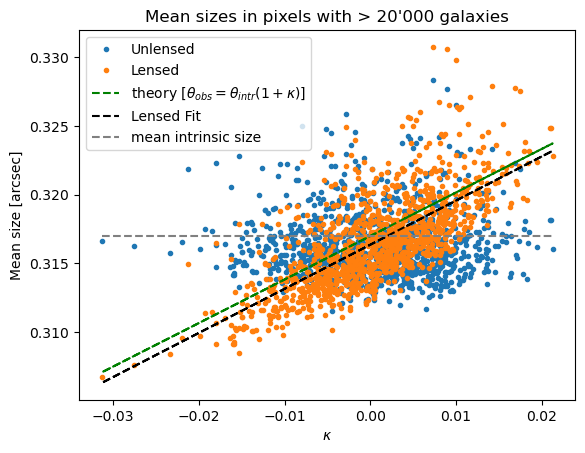

In [24]:
plt.figure()
plt.plot(kappamap_225[pixels], means_unlensed, '.', label='Unlensed')
plt.plot(kappamap_225[pixels], means_lensed, '.', label='Lensed')
plt.plot(kappamap_225[pixels], mean_theory, '--', color='g', label=r'theory $[\theta_{obs}=\theta_{intr}(1+\kappa)]$')
plt.plot(kappamap_225[pixels], m*kappamap_225[pixels]+b, '--', color='black', label='Lensed Fit')
plt.plot([np.min(kappamap_225[pixels]),np.max(kappamap_225[pixels])],[np.mean(intrinsic_size1000), np.mean(intrinsic_size1000)], '--', color='grey', label='mean intrinsic size')
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel('Mean size [arcsec]')
plt.title('Mean sizes in pixels with > 20\'000 galaxies')
plt.show()

In [25]:
# For which Pixels should the MMD be negative?

plus_min_mask = (means_lensed - np.mean(observed_size1000_masked)) < 0  # 0 = positive, 1 = negative
plus_min_mask = (-2) * plus_min_mask.astype(int) + 1    # 1 = positive, -1 = negative
plus_min_mask

array([ 1, -1, -1, ..., -1, -1, -1], shape=(1145,))

### 3.1 Computation of the MMD with Linear Kernel

In [26]:
# Compute MMDs on the Euler Cluster. The kernel matrix needs too much memory.
# Just work with the obtained results here.
"""
mmd2_lensed_linear_kernel = []
Y_lensed = observed_size1000_masked.reshape(-1,1)
for p in pixels:
    mask = (galaxy_pix1000_masked==p)
    if mask.sum()>20000:
        X = observed_size1000_masked[mask].reshape(-1,1)
        mmd2_lensed_linear_kernel.append(compute_mmd_subsample(X, Y_lensed, linear_kernel, 20000,20000,5,42))

mmd2_lensed_linear_kernel= np.array(mmd2_lensed_linear_kernel)
# np.save("MMD2_lensed_linear_kernel",mmd2_lensed_linear_kernel)
"""

mmd2_lensed_linear_kernel = np.load("MMD2_lensed_linear_kernel.npy")

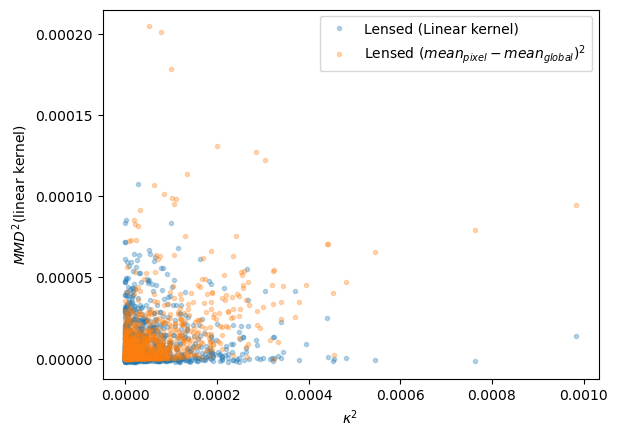

MMD² ≈ 1.173e-01 * κ² + 3.934e-06


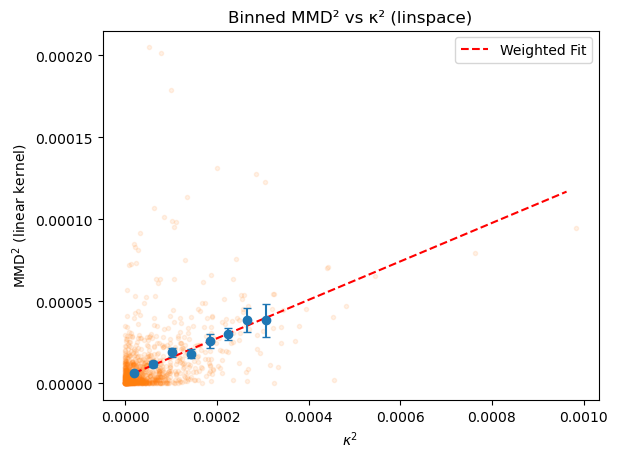

In [37]:
# Compare the values obtained with the exakt formula (mean-shift) and the (approximated) linear kernel
plt.figure()
plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_kernel, '.', label='Lensed (Linear kernel)', alpha=0.3)
plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_exakt, '.', label=r'Lensed $(mean_{pixel} - mean_{global})^2$', alpha=0.3)
plt.xlabel(r'$\kappa^2$')
plt.ylabel(r'$MMD^2$(linear kernel)')
plt.legend()
plt.show()

# ------ Binned plot of MMD² vs κ² (linspace) ------
plt.figure()
plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_exakt, '.', alpha=0.1, color='tab:orange')
plot_binned_x(x=kappamap_225[pixels]**2, y=mmd2_lensed_linear_exakt, binning_method='lin')
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
plt.title('Binned MMD² vs κ² (linspace)')
plt.legend()

### 3.2 Noise Level with exact linear kernel
Get noise level:
We get many MMDs between random samples, take their mean and std and plot it as a horizontal band. If our signal is outside of this band, we know it is a real singal.

In [38]:
mmd2_noise = []
rng = np.random.default_rng(42)

size = 20000  # match your per-pixel (or subsample) size
for _ in range(15000):
    # Xs = rng.choice(observed_size1000_masked, size=size, replace=False)
    # Ys = rng.choice(observed_size1000_masked, size=size, replace=False)
    Xs = rng.choice(observed_size1000_masked, size=size, replace=True)
    Ys = rng.choice(observed_size1000_masked, size=size, replace=True)
    mmd2_noise.append( (Xs.mean() - Ys.mean())**2 )

mmd2_noise = np.array(mmd2_noise)
noise_mean = mmd2_noise.mean()
noise_std  = mmd2_noise.std()


print("noise mean:", noise_mean, "+/-", noise_std  )

noise mean: 2.9153470949471927e-06 +/- 4.1133274462468024e-06


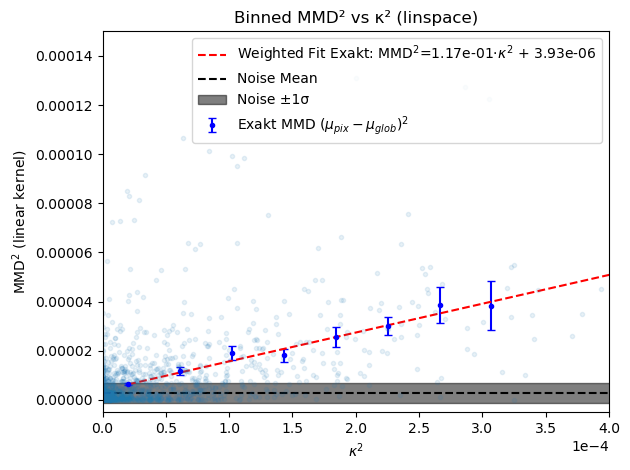

Final fit result: MMD² ≈ (1.173e-01 ± 7.7e-03) * κ² + (3.934e-06 ± 1.6e-07)
R² of the fit: 0.9695


In [39]:

plt.errorbar(xc, yc, yerr=sec, fmt='.', capsize=3, label=r'Exakt MMD $(\mu_{pix} - \mu_{glob})^2$', color='blue')
plt.plot(bin_centers, fit_params_linear[0]*bin_centers + fit_params_linear[1], 'r--', label=r'Weighted Fit Exakt: MMD$^2$={:.2e}$\cdot\kappa^2$ + {:.2e}'.format(fit_params_linear[0], fit_params_linear[1]))
plt.axhline(noise_mean, color='black', linestyle='--', label='Noise Mean')
plt.fill_between([0,0.0007], 
                 noise_mean - noise_std, 
                 noise_mean + noise_std,
                 color='black', alpha=0.5, label='Noise ±1σ')
plt.xlim(0, 0.0004)
plt.legend()
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
plt.title('Binned MMD² vs κ² (linspace)')

ax = plt.gca()

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=False)
ax.ticklabel_format(useOffset=True) # keep the scientific scale as an offset text
plt.plot(x,y, '.', alpha=0.1)
plt.ylim(-0.000005, 0.00015)
plt.tight_layout()
# plt.savefig('images/MMD2_vs_kappa2_linear.jpg', dpi=300)
plt.show()

slope, intercept = fit_params_linear
slope_err, intercept_err = np.sqrt(np.diag(cov_linear))
print(f"Final fit result: MMD² ≈ ({slope:.3e} ± {slope_err:.1e}) * κ² + ({intercept:.3e} ± {intercept_err:.1e})")

yc_preds = slope*xc + intercept
r2 = r2_score(yc, yc_preds)
print(f"R² of the fit: {r2:.4f}")

In [40]:
# Determine the kappa² limit where MMD² rises above noise + 1σ

kappa2_noise_threshold = np.linspace(0.00001, 0.00005, 50)
mmd2_noise_threshold = fit_params_linear[0]*kappa2_noise_threshold + fit_params_linear[1]

above_noise = mmd2_noise_threshold > (noise_mean + noise_std)
kappa2_limit = kappa2_noise_threshold[above_noise][0]

print(f"Kappa² limit where MMD² rises above noise + 1σ: {kappa2_limit:.2e}")

Kappa² limit where MMD² rises above noise + 1σ: 2.71e-05


<a id='section4'></a>
## 4. Finer Convergence Map
Now we want to apply a finer/smoother convergence map to the galaxies. We will then compute the MMD of the coarser pixels, such that each coarser pixel represents a neighbourhood of galaxies with slightly different kappas. 

In [41]:
# Create a smoother convergence map.
nside_fine = 1024

kappamap_fine = hp.synfast( cl_kappa_225, nside_fine)

# Convert galaxy coordinates to pixel numbers in the finer map
gal_pix_fine = hp.ang2pix(nside_fine, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
gal_pix_fine_unique, gal_pix_fine_counts = np.unique(gal_pix_fine, return_counts=True)

print("Galaxy pixels:",gal_pix_fine, "   Length of Galaxy pixels(should match nr. of galaxies):", len(gal_pix_fine))
print("Number of unique pixels with galaxies:", len(gal_pix_fine_unique))
print("Max number of galaxies in a pixel:", np.max(gal_pix_fine_counts))
print("Min number of galaxies in a pixel:", np.min(gal_pix_fine_counts))
print("Mean number of galaxies in a pixel:", np.mean(gal_pix_fine_counts))
print("Number of pixels with > 20'000 galaxies:", np.sum(gal_pix_fine_counts >= 20000))
print('-'*30)


# Compute observed sizes for all galaxies using the finer kappa map
observed_size_fine = intrinsic_size1000 * (1.0 + kappamap_fine[gal_pix_fine])


Galaxy pixels: [4372481 4368384 4376574 ... 8214525 8210426 8218620]    Length of Galaxy pixels(should match nr. of galaxies): 31574550
Number of unique pixels with galaxies: 302660
Max number of galaxies in a pixel: 157
Min number of galaxies in a pixel: 1
Mean number of galaxies in a pixel: 104.32349831494086
Number of pixels with > 20'000 galaxies: 0
------------------------------


<a id='section5'></a>
## 5. Creating an Estimator

What we will do here:
- On Euler, we will create a new fine convergence map kappa_est_fine. (set random seed = 19)!
- We will apply this convergence to the intrinsic sizes
- Compute the MMD^2 between coarse pixel and global distribution
- Compute the average kappa in each coarse pixel

- Upload here the kappa_avg_est and MMD2_rbf_est
- Compute mean-shift
- Plot as above sgn(kappa)*kappa^2 vs +/- MMD2 (the sign of the MMD is given by mean-shift)
- Fit the binned values and get an estimator.


### 5.1 Directed RBF Kernel

In [42]:
mmd2_dir_rbf_fine_batch1 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_1.npy")
mmd2_dir_rbf_fine_batch2 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_2.npy")
mmd2_dir_rbf_fine_batch3 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_3.npy")
mmd2_dir_rbf_fine_batch4 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_4.npy")
mmd2_dir_rbf_fine_batch5 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_5.npy")
mmd2_dir_rbf_fine_batch6 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_6.npy")
mmd2_dir_rbf_fine_batch7 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_7.npy")
mmd2_dir_rbf_fine_batch8 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_8.npy")
mmd2_dir_rbf_fine_batch9 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_9.npy")
mmd2_dir_rbf_fine_batch10 = np.load(f"mmd2_dir_rbf_fine3/mmd2_dir_rbf_fine_batch_10.npy")

mmd2_dir_rbf_fine = np.concatenate((mmd2_dir_rbf_fine_batch1, mmd2_dir_rbf_fine_batch2,
                                    mmd2_dir_rbf_fine_batch3, mmd2_dir_rbf_fine_batch4,
                                    mmd2_dir_rbf_fine_batch5, mmd2_dir_rbf_fine_batch6,
                                    mmd2_dir_rbf_fine_batch7, mmd2_dir_rbf_fine_batch8,
                                    mmd2_dir_rbf_fine_batch9, mmd2_dir_rbf_fine_batch10), axis=0)
kappa_avg_fine4 = np.load('kappa_avg_fine4.npy')
mask_20k_gals = galaxy_pix1000_counts >= 20000
kappa_avg_fine4 = kappa_avg_fine4[mask_20k_gals]

signed_kappa2_avg_fine4 = np.sign(kappa_avg_fine4) * kappa_avg_fine4**2
mmd2_dir_rbf_fine = (-1) * mmd2_dir_rbf_fine  # Correct sign convention

print(f"Percentage of correctly assigned signs in fine map MMD: {100 * ((np.sign(mmd2_dir_rbf_fine)== np.sign(signed_kappa2_avg_fine4)).sum())/len(mmd2_dir_rbf_fine):.2f}%")

Percentage of correctly assigned signs in fine map MMD: 71.35%


MMD ≈ 8.307e+01 * κ + -3.093e-03


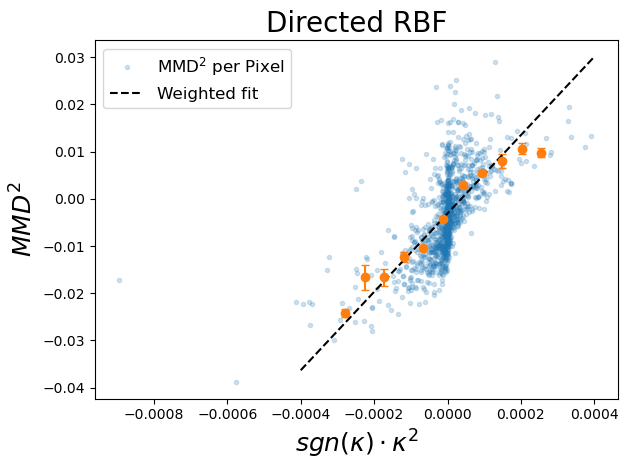

Slope: 83.06667869210528 ± 7.612922420391318
Intercept: -0.003092524058380945 ± 0.00036170568803839187
R² score for estimation fit: 0.9183


In [43]:
fig2 = plt.figure()
est_dir_xc, est_dir_yc, est_sec, est_dir_fit, est_cov_fit = binning_and_plotting(signed_kappa2_avg_fine4, mmd2_dir_rbf_fine, n_bins=24)
plt.plot(np.linspace(-0.0004, 0.0004, 10), est_dir_fit[0]*np.linspace(-0.0004, 0.0004, 10) + est_dir_fit[1], linestyle='--', color='black', label='Weighted fit')
plt.xlabel(r'$sgn(\kappa)\cdot\kappa^2$', fontsize=18)
plt.ylabel(r'$MMD^2$', fontsize=18)
plt.title(r'Directed RBF', fontsize=20)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
# plt.savefig("images/estimator_mmd2_vs_kappa2_dir_rbf.jpg", dpi=300)
plt.show()

slope, intercept = est_dir_fit
slope_unc, intercept_unc = np.sqrt(np.diag(est_cov_fit))

print(f"Slope: {slope} ± {slope_unc}")
print(f"Intercept: {intercept} ± {intercept_unc}")
est_dir_yc_preds = slope * est_dir_xc + intercept
r2_est_dir = r2_score(est_dir_yc, est_dir_yc_preds)
print(f"R² score for estimation fit: {r2_est_dir:.4f}"  )

### 5.2 RBF Kernel

In [44]:
estimator_seed = 19
np.random.seed(estimator_seed)
estimator_kappamap = hp.synfast(cl_kappa_225, nside_fine)
estimator_observed_size = intrinsic_size1000 * (1.0 + estimator_kappamap[gal_pix_fine])

# Could/Should be also computed on Euler:
means_est_fine = []
for pix in galaxy_pix1000_unique:
    mask = (galaxy_pix1000 == pix)
    if sum(mask) > 20000:
        means_est_fine.append(np.mean(estimator_observed_size[mask]))

means_est_fine = np.array(means_est_fine)
sign_est_fine = np.sign(means_est_fine - estimator_observed_size.mean())

In [45]:
mmd2_est_rbf_fine_batch1 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_1.npy")
mmd2_est_rbf_fine_batch2 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_2.npy")
mmd2_est_rbf_fine_batch3 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_3.npy")
mmd2_est_rbf_fine_batch4 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_4.npy")
mmd2_est_rbf_fine_batch5 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_5.npy")
mmd2_est_rbf_fine_batch6 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_6.npy")
mmd2_est_rbf_fine_batch7 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_7.npy")
mmd2_est_rbf_fine_batch8 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_8.npy")
mmd2_est_rbf_fine_batch9 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_9.npy")
mmd2_est_rbf_fine_batch10 = np.load(f"mmd2_est_rbf_fine2/mmd2_est_rbf_fine_batch_10.npy")

mmd2_est_rbf_fine = np.concatenate((mmd2_est_rbf_fine_batch1, mmd2_est_rbf_fine_batch2,
                                    mmd2_est_rbf_fine_batch3, mmd2_est_rbf_fine_batch4,
                                    mmd2_est_rbf_fine_batch5, mmd2_est_rbf_fine_batch6,
                                    mmd2_est_rbf_fine_batch7, mmd2_est_rbf_fine_batch8,
                                    mmd2_est_rbf_fine_batch9, mmd2_est_rbf_fine_batch10), axis=0)

kappa_est_avg_fine3 = np.load('kappa_avg_fine4.npy')
kappa_est_avg_fine3 = kappa_est_avg_fine3[mask_20k_gals]

signed_kappa2_est_fine3 = np.sign(kappa_est_avg_fine3) * kappa_est_avg_fine3**2
signed_mmd2_est_rbf = sign_est_fine * mmd2_est_rbf_fine
print(f"Percentage of correctly assigned signs via Mean-Shift: {100 * ((sign_est_fine == np.sign(kappa_est_avg_fine3)).sum())/len(sign_est_fine):.2f} %")


Percentage of correctly assigned signs via Mean-Shift: 74.41 %


MMD ≈ 2.257e-01 * κ + 1.207e-06


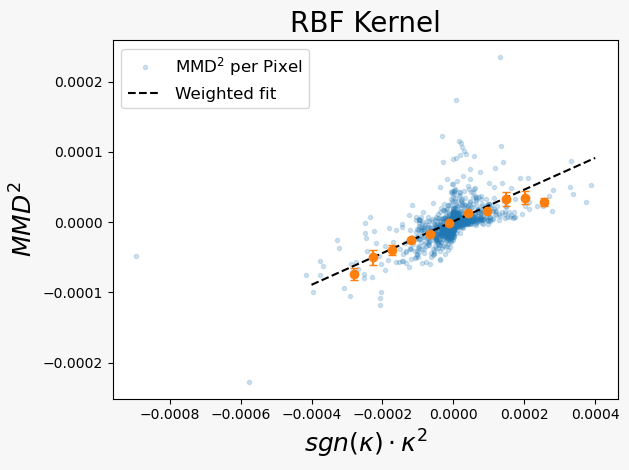

Slope: 0.22574402809305535 ± 0.021294137709770285
Intercept: 1.2068132988662182e-06 ± 5.015496469423478e-07
R² score for estimation fit: 0.9072


In [46]:
fig = plt.figure()
est_rbf_xc, est_rbf_yc, est_rbf_sec, est_rbf_fit, est_rbf_cov_fit = binning_and_plotting(signed_kappa2_est_fine3, signed_mmd2_est_rbf, n_bins=24, Title=r'Binned MMD² vs $sgn(\kappa)\cdot\kappa^2$ (Estimation Map, RBF)', plot=True)
plt.plot(np.linspace(-0.0004, 0.0004, 10), est_rbf_fit[0]*np.linspace(-0.0004, 0.0004, 10) + est_rbf_fit[1], linestyle='--', color='black', label='Weighted fit')
plt.xlabel(r'$sgn(\kappa)\cdot\kappa^2$', fontsize=18)
plt.ylabel(r'$MMD^2$', fontsize=18)
plt.title(r'RBF Kernel', fontsize=20)
plt.tight_layout()
# plt.savefig("images/estimator_mmd2_vs_kappa2_rbf.jpg", dpi=300)
plt.legend(loc='upper left', fontsize=12)
bg_color = '#F7F7F7'
fig.patch.set_facecolor(bg_color)
plt.show()

slope, intercept = est_rbf_fit
slope_unc, intercept_unc = np.sqrt(np.diag(est_rbf_cov_fit))

print(f"Slope: {slope} ± {slope_unc}")
print(f"Intercept: {intercept} ± {intercept_unc}")
est_rbf_yc_preds = slope * est_rbf_xc + intercept
r2_est_rbf = r2_score(est_rbf_yc, est_rbf_yc_preds)
print(f"R² score for estimation fit: {r2_est_rbf:.4f}"  )


<a id='section6'></a>
## 6. Recovery of the Convergence Map and Power Spectrum
We create a new convergence map. Apply it to the intrinsic galaxy sizes and compute the MMD just as before. We compute the MMD with RBF and directed RBF kernel. Then use the estimators we obtained above with the earlier kappamap_fine to try to recover the kappa values of the new convergence map.


### 6.1 RBF Kernel

We recover the convergence map (seed=31) from the MMD measurements with the RBF kernel. 

We created the map, computed the MMD2s and obbtained the signs (via mean-shift) with the python script on the euler cluster.

In [47]:
# Create and apply new convergence map for RECOVERY test
recovery_rand_seed = 31
np.random.seed(recovery_rand_seed)
recovery_kappamap = hp.synfast(cl_kappa_225, nside_fine)
recovery_observed_size = intrinsic_size1000 * (1.0 + recovery_kappamap[gal_pix_fine])

means_recov_fine = []
for pix in galaxy_pix1000_unique:
    mask = (galaxy_pix1000 == pix)
    if sum(mask) > 20000:
        means_recov_fine.append(np.mean(recovery_observed_size[mask]))

means_recov_fine = np.array(means_recov_fine)
sign_recov_fine = np.sign(means_recov_fine - recovery_observed_size.mean())

In [48]:
# Load the computed MMDs, and avg kappa values in the coarser pixels
mmd2_recov_rbf_batch1 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_1.npy")
mmd2_recov_rbf_batch2 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_2.npy")
mmd2_recov_rbf_batch3 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_3.npy")
mmd2_recov_rbf_batch4 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_4.npy")
mmd2_recov_rbf_batch5 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_5.npy")
mmd2_recov_rbf_batch6 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_6.npy")
mmd2_recov_rbf_batch7 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_7.npy")
mmd2_recov_rbf_batch8 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_8.npy")
mmd2_recov_rbf_batch9 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_9.npy")
mmd2_recov_rbf_batch10 = np.load(f"mmd2_recov_rbf/mmd2_lensed_rbf_fine_batch_10.npy")

mmd2_recov_rbf = np.concatenate((mmd2_recov_rbf_batch1, mmd2_recov_rbf_batch2,
                                 mmd2_recov_rbf_batch3, mmd2_recov_rbf_batch4,
                                 mmd2_recov_rbf_batch5, mmd2_recov_rbf_batch6,
                                 mmd2_recov_rbf_batch7, mmd2_recov_rbf_batch8,
                                 mmd2_recov_rbf_batch9, mmd2_recov_rbf_batch10), axis=0)

kappa_recov_avg_fine = np.load('kappa_recov_avg_fine.npy')
kappa_recov_avg_fine = kappa_recov_avg_fine[mask_20k_gals]      # Want to predict these kappa values

signed_kappa2_recov = np.sign(kappa_recov_avg_fine) * kappa_recov_avg_fine**2   # Correct sign assignments: 887/1145
signed_mmd2_recov_rbf = sign_recov_fine * mmd2_recov_rbf

### 6.2 Directed RBF Kernel
Now we do the same as above, but with the MMDs measured with the custom directed RBF kernel.

 Note: Same convergence map.

In [50]:
mmd2_recov_dir_rbf_batch1 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_1.npy")
mmd2_recov_dir_rbf_batch2 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_2.npy")
mmd2_recov_dir_rbf_batch3 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_3.npy")
mmd2_recov_dir_rbf_batch4 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_4.npy")
mmd2_recov_dir_rbf_batch5 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_5.npy")
mmd2_recov_dir_rbf_batch6 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_6.npy")
mmd2_recov_dir_rbf_batch7 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_7.npy")
mmd2_recov_dir_rbf_batch8 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_8.npy")
mmd2_recov_dir_rbf_batch9 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_9.npy")
mmd2_recov_dir_rbf_batch10 = np.load(f"mmd2_recov_dir_rbf/mmd2_lensed_dir_rbf_fine_batch_10.npy")

mmd2_recov_dir_rbf_fine = np.concatenate((mmd2_recov_dir_rbf_batch1, mmd2_recov_dir_rbf_batch2,
                                           mmd2_recov_dir_rbf_batch3, mmd2_recov_dir_rbf_batch4,
                                           mmd2_recov_dir_rbf_batch5, mmd2_recov_dir_rbf_batch6,
                                           mmd2_recov_dir_rbf_batch7, mmd2_recov_dir_rbf_batch8,
                                           mmd2_recov_dir_rbf_batch9, mmd2_recov_dir_rbf_batch10), axis=0)
mmd2_recov_dir_rbf_fine = (-1) * mmd2_recov_dir_rbf_fine  # Correct sign convention


### 6.3 Pixelwise Recovery
We predict and compare the convergence value for each individual coarse pixel.

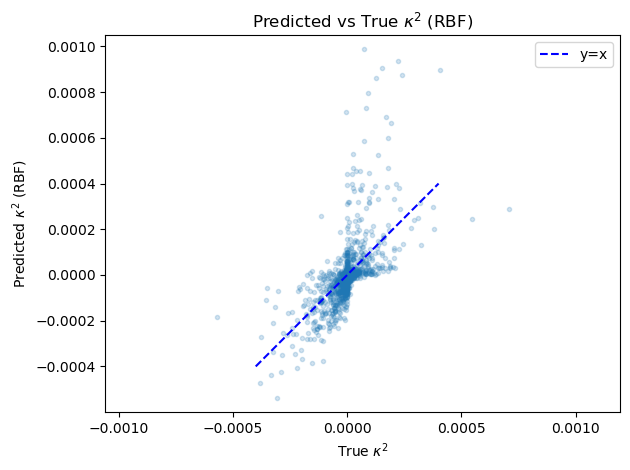

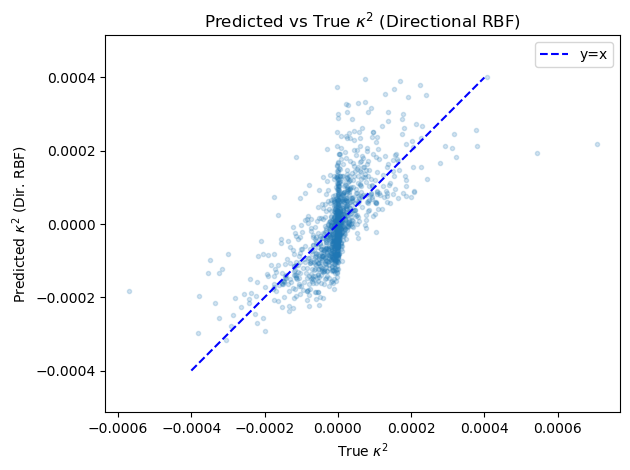

In [51]:
# RBF Kernel
pred_kappa2_rbf = signed_mmd2_recov_rbf/est_rbf_fit[0] - est_rbf_fit[1]/est_rbf_fit[0]
pred_kappa_rbf = np.sign(pred_kappa2_rbf) * np.sqrt(np.abs(pred_kappa2_rbf))
plt.figure()
plt.plot(signed_kappa2_recov, pred_kappa2_rbf, '.', alpha=0.2)
plt.axis('equal')
x = np.array([-0.0004, 0.0004])
plt.plot(x,x, 'b--', label='y=x')
plt.legend()
plt.xlabel(r'True $\kappa^2$')
plt.ylabel(r'Predicted $\kappa^2$ (RBF)')
plt.title('Predicted vs True $\kappa^2$ (RBF)')
plt.tight_layout()
plt.show()

# Directed RBF Kernel
pred_kappa2_dir_rbf = mmd2_recov_dir_rbf_fine/est_dir_fit[0] - est_dir_fit[1]/est_dir_fit[0]
pred_kappa_dir_rbf = np.sign(pred_kappa2_dir_rbf) * np.sqrt(np.abs(pred_kappa2_dir_rbf))
plt.figure()
plt.plot(signed_kappa2_recov, pred_kappa2_dir_rbf, '.', alpha=0.2,)
plt.axis('equal')
x = np.array([-0.0004, 0.0004])
plt.plot(x,x, 'b--', label='y=x')
plt.legend()
plt.xlabel(r'True $\kappa^2$')
plt.ylabel(r'Predicted $\kappa^2$ (Dir. RBF)')
plt.title('Predicted vs True $\kappa^2$ (Directional RBF)')
plt.tight_layout()
# plt.savefig("images/predicted_vs_true_kappa2_directional_rbf.jpg", dpi=300)
plt.show()

Residuals > 0: 439 Residuals < 0: 706
Residuals vs kapp correlation coeff. : -0.0752031185425163
Residuals > 0: 528 Residuals < 0: 617
Residuals vs kapp correlation coeff. : -0.02038755448089843
Comparison map saved to images/kappa_comparison_rbf.jpg
Comparison map saved to images/kappa_comparison_directional_rbf.jpg


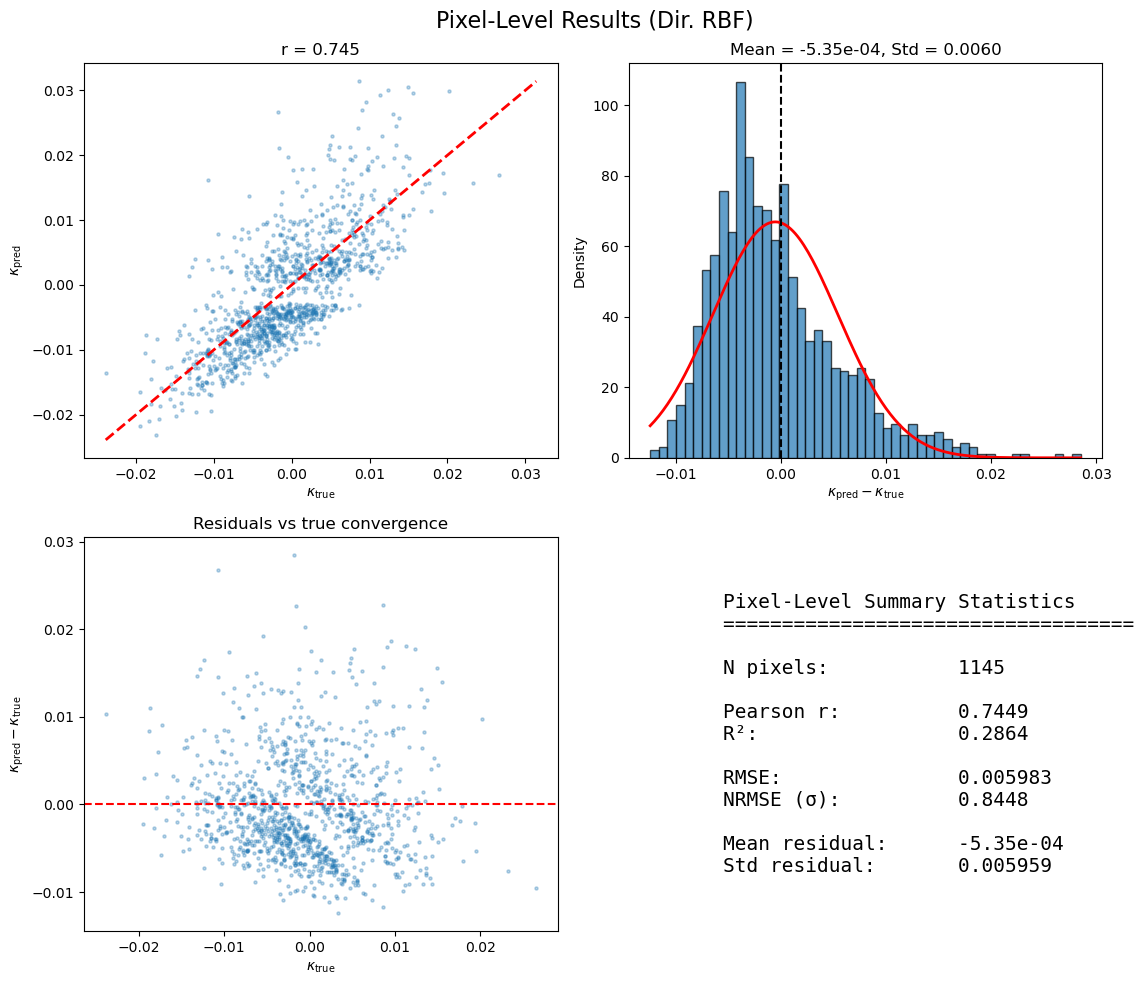

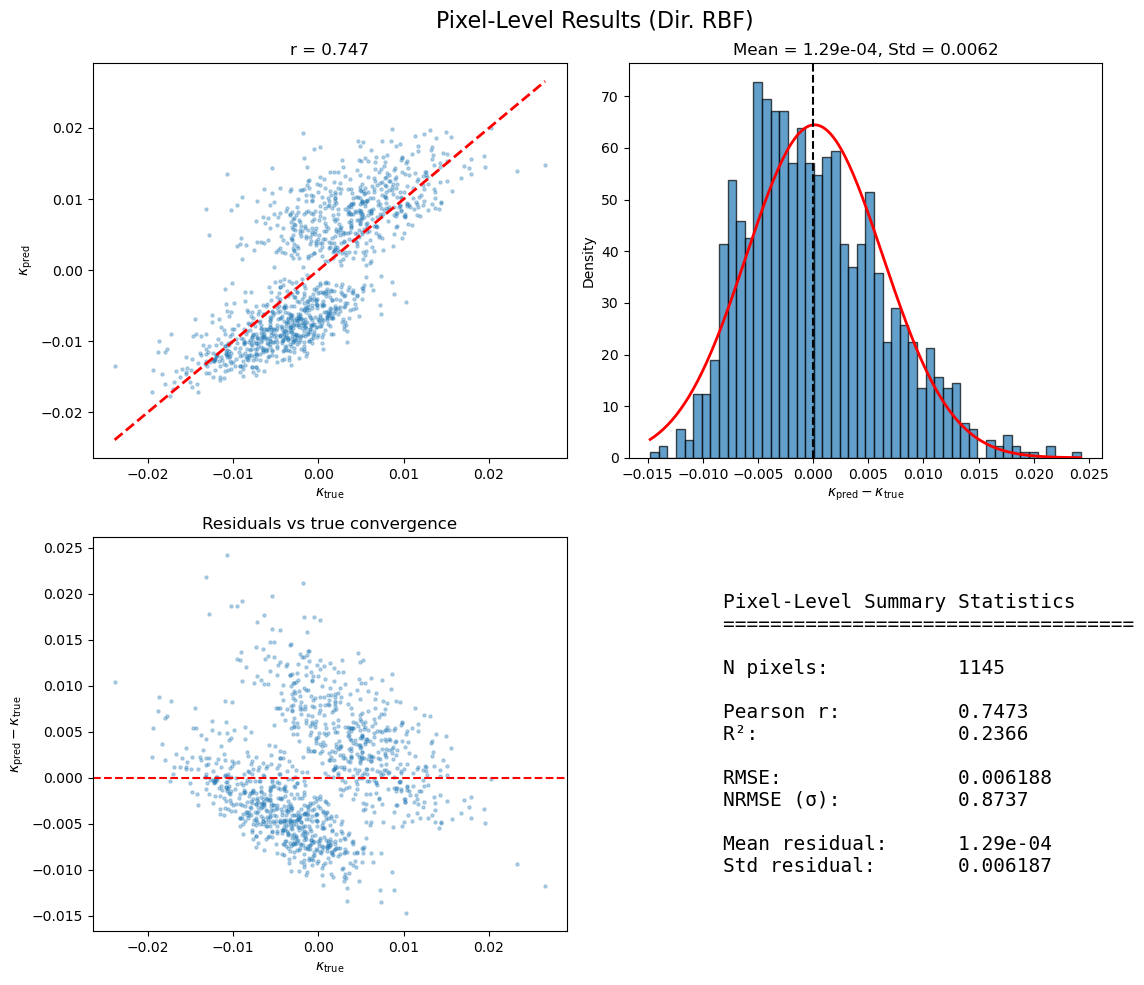

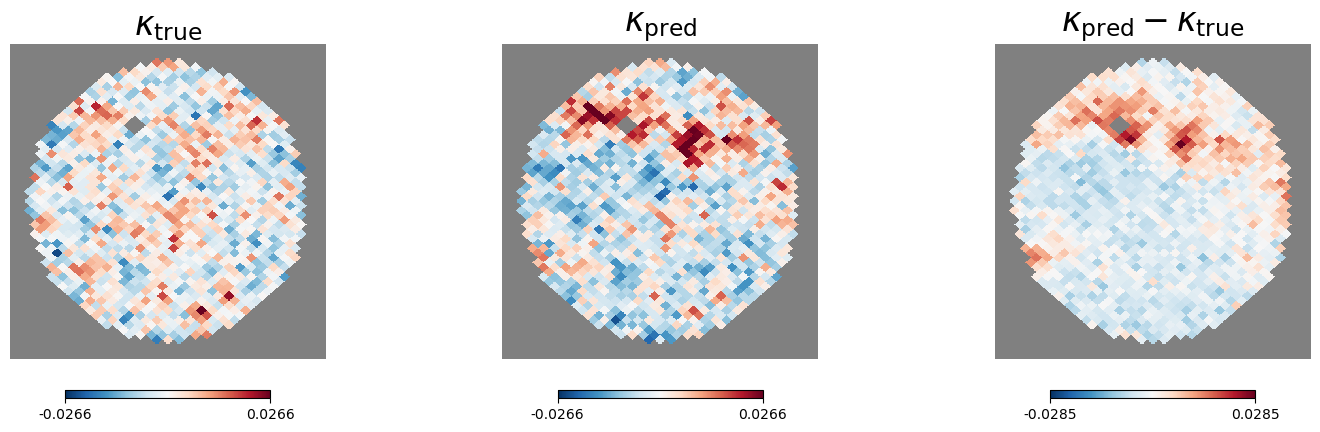

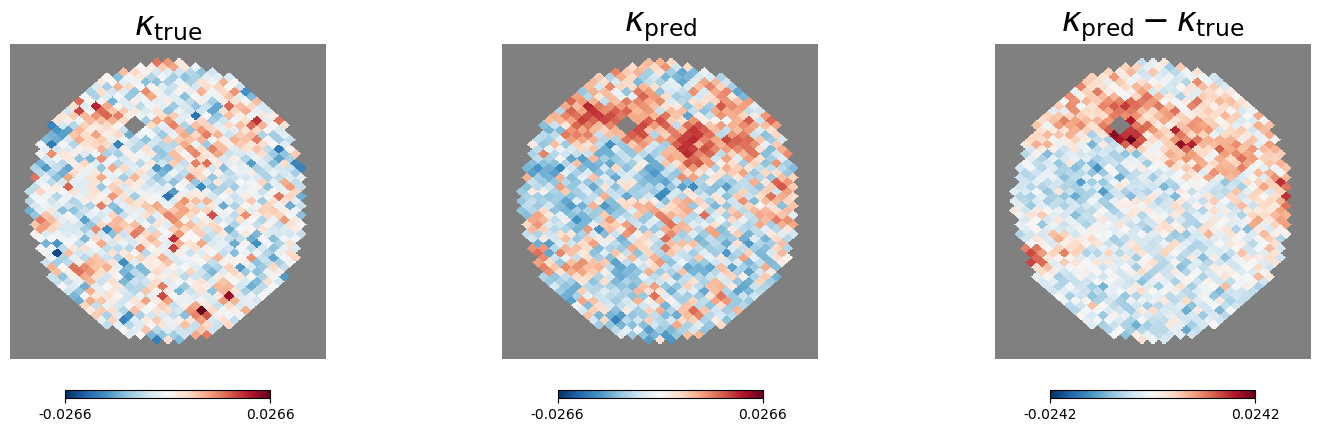

In [52]:
# ----- Pixel-level results plots -----

ax1 = plot_pixel_level_results(kappa_recov_avg_fine, pred_kappa_rbf)
# plt.savefig("images/pixel_level_results_rbf.jpg", dpi=300)
ax2 = plot_pixel_level_results(kappa_recov_avg_fine, pred_kappa_dir_rbf)
# plt.savefig("images/pixel_level_results_dir_rbf.jpg", dpi=300)

plot_kappa_comparison_maps(kappa_recov_avg_fine, pred_kappa_rbf, galaxy_pix1000_unique[mask_20k_gals], nside=64, save_path='images/kappa_comparison_rbf.jpg')
# plt.savefig('images/kappamap_comparison_rbf.jpg', dpi=300)
plot_kappa_comparison_maps(kappa_recov_avg_fine, pred_kappa_dir_rbf, galaxy_pix1000_unique[mask_20k_gals], nside=64, save_path='images/kappa_comparison_directional_rbf.jpg')
# plt.savefig('images/kappamap_comparison_dir_rbf.jpg', dpi=300)

### 6.4 Recovery of Statistics
First, we compute the Gaussian statistics of the predicted field.
This involves getting a zero-mean, comparing standard deviation, skewness and kurtosis.

In [53]:
compute_gaussian_stats(pred_kappa_dir_rbf)
compute_gaussian_stats(kappa_recov_avg_fine)

MEAN = -5.3982e-04 
STD = 9.3082e-03 
Skewness = 2.4461e-01 
Kurtosis = -1.2721e+00
--------------------
MEAN = -6.6890e-04 
STD = 7.0821e-03 
Skewness = 1.2429e-01 
Kurtosis = 6.5904e-02
--------------------


(np.float64(-0.0006689014256402407),
 np.float64(0.007082065621405918),
 np.float64(0.12429197892905879),
 np.float64(0.06590361066964867))

MEAN = -1.2040e-03 
STD = 8.9059e-03 
Skewness = 6.5182e-01 
Kurtosis = 5.0774e-01
--------------------


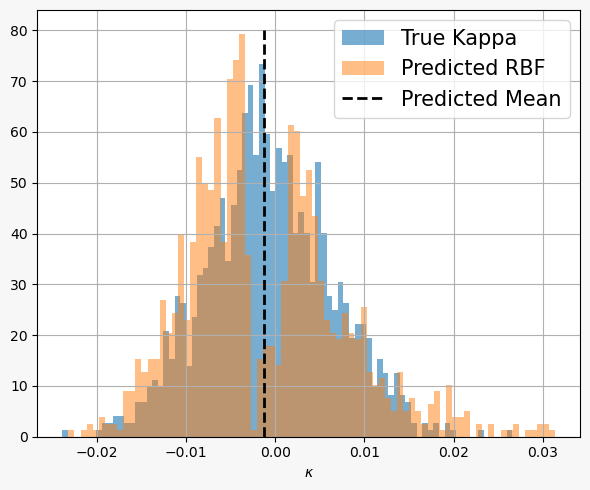

MEAN = -5.3982e-04 
STD = 9.3082e-03 
Skewness = 2.4461e-01 
Kurtosis = -1.2721e+00
--------------------


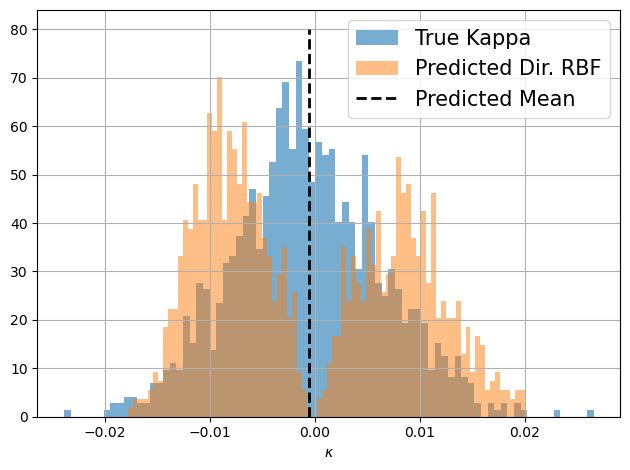

In [56]:
# ----- Histograms of true vs predicted kappa -----
mean, _, _, _ = compute_gaussian_stats(pred_kappa_rbf)
fig = plt.figure(figsize=(6, 5))
fig.patch.set_facecolor(bg_color)
plt.hist(kappa_recov_avg_fine, bins=80, density=True, alpha=0.6, label='True Kappa')
plt.hist(pred_kappa_rbf, bins=80, density=True, alpha=0.5, label='Predicted RBF')
plt.vlines(mean, ymin=0, ymax=80, color='black', linestyle='--', label='Predicted Mean', linewidth=2)
plt.xlabel(r'$\kappa$')
plt.legend(fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('images/kappa_hist_rbf.jpg', dpi=300)
plt.show()

mean_dir, _, _, _ = compute_gaussian_stats(pred_kappa_dir_rbf)
plt.figure()
plt.hist(kappa_recov_avg_fine, bins=80, density=True, alpha=0.6, label='True Kappa')
plt.hist(pred_kappa_dir_rbf, bins=80, density=True, alpha=0.5, label='Predicted Dir. RBF')
plt.vlines(mean_dir, ymin=0, ymax=80, color='black', linestyle='--', label='Predicted Mean', linewidth=2)
plt.xlabel(r'$\kappa$')
plt.legend(fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('images/kappa_hist_dir_rbf.jpg', dpi=300)
plt.show()

Next, we compute the Power Spectrum.

1.0
1.0
1.0


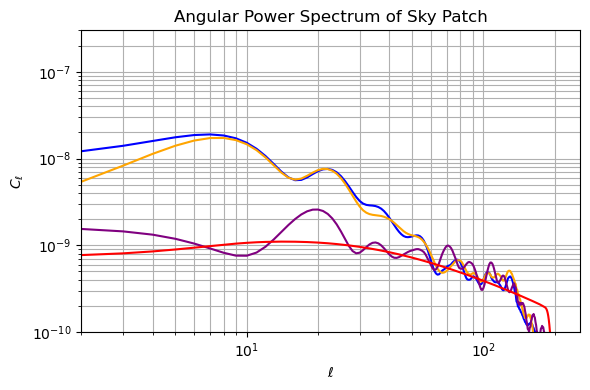

In [58]:
pseudo_cl = np.loadtxt("pseudo_cl.txt")

full_map_rbf = np.zeros(hp.nside2npix(64))
full_map_rbf[galaxy_pix1000_unique[mask_20k_gals]] = pred_kappa_rbf

full_map_dir_rbf = np.zeros(hp.nside2npix(64))
full_map_dir_rbf[galaxy_pix1000_unique[mask_20k_gals]] = pred_kappa_dir_rbf

full_map_perf1 = np.zeros(hp.nside2npix(64))
full_map_perf2 = np.zeros(hp.nside2npix(64))
full_map_perf1[galaxy_pix1000_unique[mask_20k_gals]] = kappamap_225[galaxy_pix1000_unique[mask_20k_gals]]
# full_map_perf1[galaxy_pix1000_unique[mask_20k_gals]] = kappa_avg_fine4[galaxy_pix1000_unique[mask_20k_gals]]  # Perfect recovery
full_map_perf2[galaxy_pix1000_unique[mask_20k_gals]] = recovery_kappamap[galaxy_pix1000_unique[mask_20k_gals]]  # Perfect recovery

# map: 1D array of convergence values, zeros where unobserved
mean_subtracted_rbf = full_map_rbf - np.mean(full_map_rbf[full_map_rbf != 0])   #Remove monopole
cls_raw_rbf = hp.anafast(mean_subtracted_rbf, lmax=256)
f_sky_rbf = np.count_nonzero(mean_subtracted_rbf) / mean_subtracted_rbf.size
print(f_sky_rbf)
cls_corr_rbf = cls_raw_rbf / f_sky_rbf

mean_subtracted_dir_rbf = full_map_dir_rbf - np.mean(full_map_dir_rbf[full_map_dir_rbf != 0])   #Remove monopole
cls_raw_dir_rbf = hp.anafast(mean_subtracted_dir_rbf, lmax=256)
f_sky_dir_rbf = np.count_nonzero(mean_subtracted_dir_rbf) / mean_subtracted_dir_rbf.size
print(f_sky_dir_rbf)
cls_corr_dir_rbf = cls_raw_dir_rbf / f_sky_dir_rbf

mean_subtracted_perf = full_map_perf1 - np.mean(full_map_perf1[full_map_perf1 != 0])   #Remove monopole
cls_raw_perf = hp.anafast(mean_subtracted_perf, lmax=256)
f_sky_perf = np.count_nonzero(mean_subtracted_perf) / mean_subtracted_perf.size
print(f_sky_perf)
cls_corr_perf = cls_raw_perf / f_sky_perf



ell = np.arange(len(cls_corr_rbf))
plt.figure(figsize=(6,4))
plt.plot(cls_corr_rbf, label='Recovered Power Spectrum: RBF', color='blue')
plt.plot(cls_corr_dir_rbf, label='Recovered Power Spectrum: Dir. RBF', color='orange')
plt.plot(cls_corr_perf, label='Recovered Kappa Power Spectrum (Perfect)', color='purple')
plt.plot(pseudo_cl, label=r'Pseudo Power Spectrum', color='red')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.title('Angular Power Spectrum of Sky Patch')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10, 3*1e-7)
plt.xlim(2, 256)
plt.grid(True, which='both')
plt.tight_layout()
plt.gca().set_aspect('auto', adjustable='box')
# plt.legend()
# plt.savefig("images/power_spectrum_comparison.jpg", dpi=300)
plt.show()

<a id='section7'></a>
## 7. Recovery of new Convergence Map for Validation
We create a new Galaxy distribution by resampling the position of each galaxy. 

In [59]:
val_seed = 29
np.random.seed(val_seed)

# Draw new random positions of the galaxies
ra_max, ra_min = catalogue1000['ra'].max(), catalogue1000['ra'].min()
dec_max, dec_min = catalogue1000['dec'].max(), catalogue1000['dec'].min()

new_ra = np.random.uniform(ra_min, ra_max, size=catalogue1000.shape[0])
new_dec = np.random.uniform(dec_min, dec_max, size=catalogue1000.shape[0])

# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix1000_val = hp.ang2pix(nside, new_ra, new_dec, lonlat=True)
galaxy_pix1000_unique_val, galaxy_pix1000_counts_val = np.unique(galaxy_pix1000_val, return_counts=True)

mask_20k_gals_val = galaxy_pix1000_counts_val >= 20000

In [60]:
means_val_fine = np.load('mmd2_val_rbf/means_val_fine.npy')
sign_val_fine = np.load('mmd2_val_rbf/sign_val_fine.npy')
mmd2_val_rbf_batch1 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_1.npy")
mmd2_val_rbf_batch2 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_2.npy")
mmd2_val_rbf_batch3 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_3.npy")
mmd2_val_rbf_batch4 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_4.npy")
mmd2_val_rbf_batch5 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_5.npy")
mmd2_val_rbf_batch6 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_6.npy")
mmd2_val_rbf_batch7 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_7.npy")
mmd2_val_rbf_batch8 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_8.npy")
mmd2_val_rbf_batch9 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_9.npy")
mmd2_val_rbf_batch10 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_10.npy")
mmd2_val_rbf_batch11 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_11.npy")
mmd2_val_rbf_batch12 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_12.npy")
mmd2_val_rbf_batch13 = np.load(f"mmd2_val_rbf/mmd2_val_rbf_fine_batch_13.npy")

mmd2_val_rbf = np.concatenate((mmd2_val_rbf_batch1, mmd2_val_rbf_batch2,
                               mmd2_val_rbf_batch3, mmd2_val_rbf_batch4,
                               mmd2_val_rbf_batch5, mmd2_val_rbf_batch6,
                               mmd2_val_rbf_batch7, mmd2_val_rbf_batch8,
                               mmd2_val_rbf_batch9, mmd2_val_rbf_batch10,
                               mmd2_val_rbf_batch11, mmd2_val_rbf_batch12,
                               mmd2_val_rbf_batch13), axis=0)
kappa_val_avg_fine = np.load('mmd2_val_rbf/kappa_val_avg_fine_masked.npy')

signed_kappa2_val = np.sign(kappa_val_avg_fine) * kappa_val_avg_fine**2
signed_mmd2_val_rbf = sign_val_fine * mmd2_val_rbf

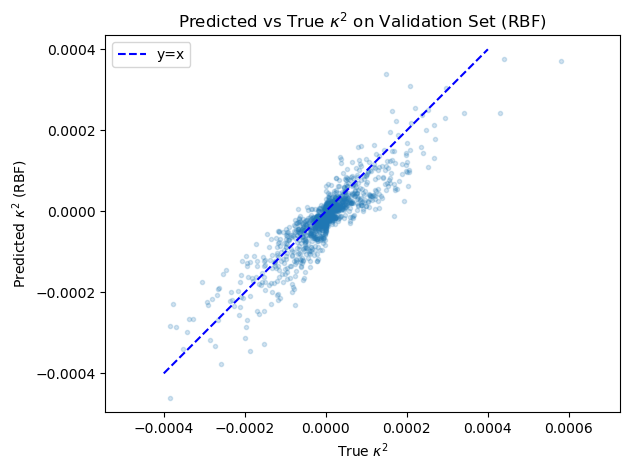

Residuals > 0: 404 Residuals < 0: 992
Residuals vs kapp correlation coeff. : -0.30083811011141787
Comparison map saved to None


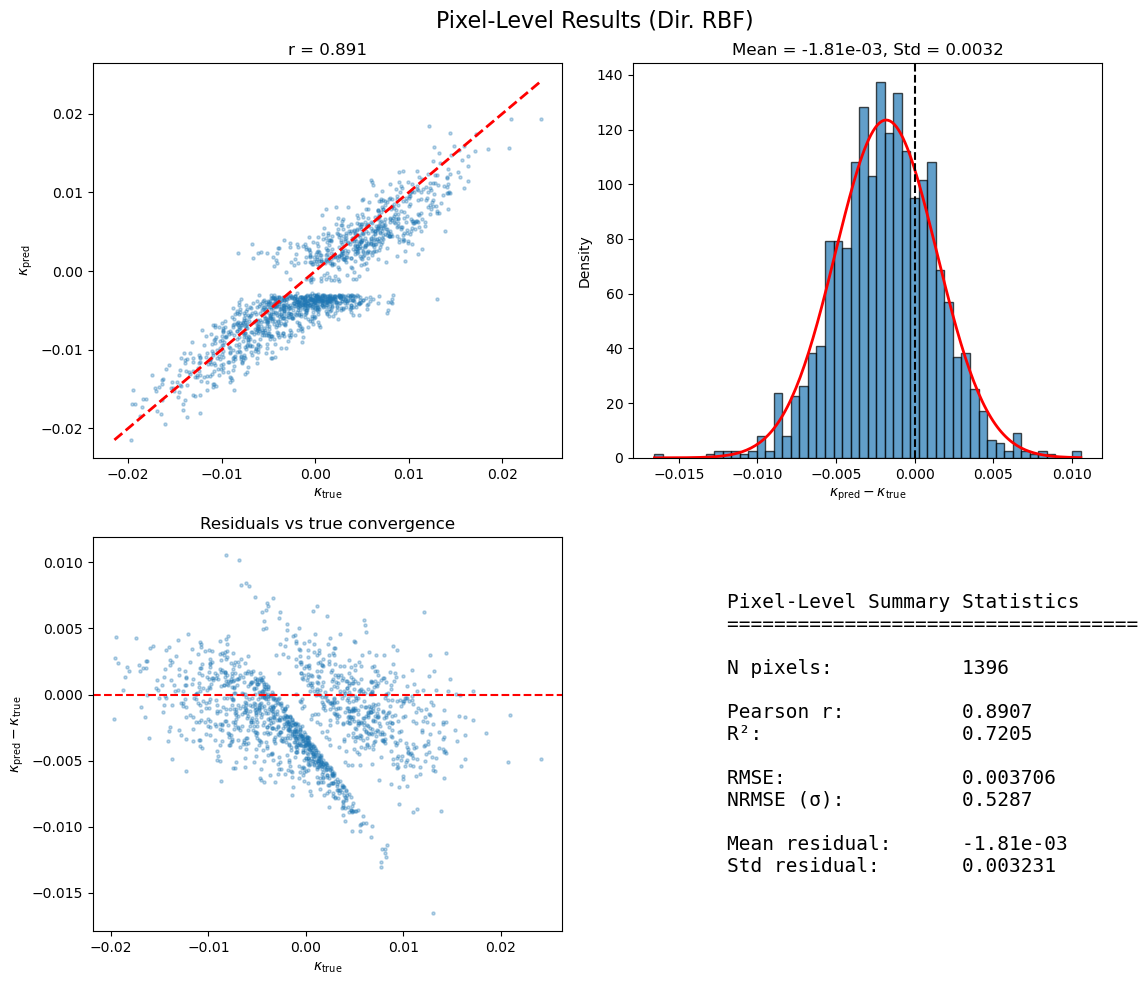

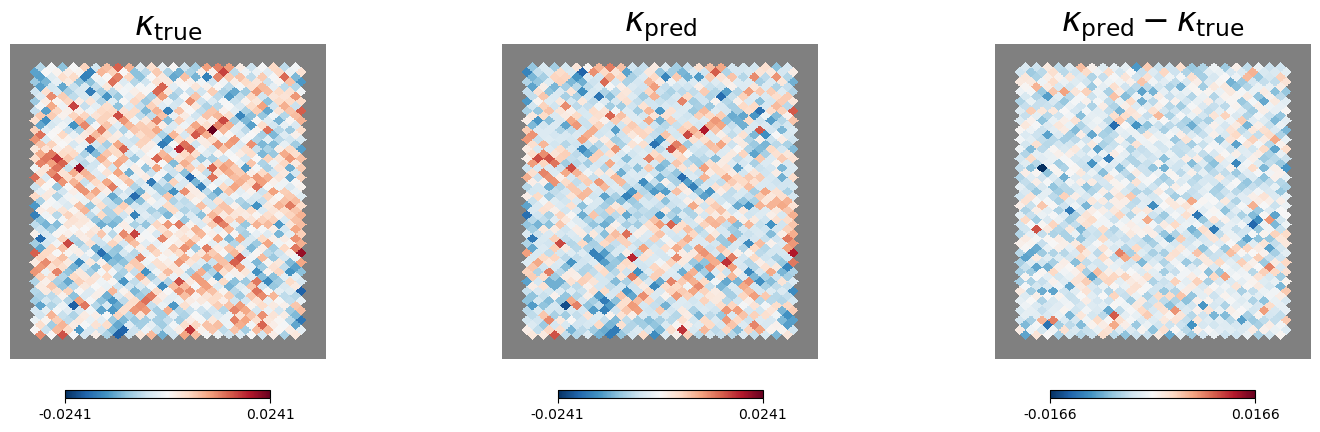

In [61]:
pred_kappa2_val = signed_mmd2_val_rbf/est_rbf_fit[0] - est_rbf_fit[1]/est_rbf_fit[0]
pred_kappa_val = np.sign(pred_kappa2_val) * np.sqrt(np.abs(pred_kappa2_val))

plt.figure()
plt.plot(signed_kappa2_val, pred_kappa2_val, '.', alpha=0.2)
plt.axis('equal')
x = np.array([-0.0004, 0.0004])
plt.plot(x,x, 'b--', label='y=x')
plt.legend()
plt.xlabel(r'True $\kappa^2$')
plt.ylabel(r'Predicted $\kappa^2$ (RBF)')
plt.title('Predicted vs True $\kappa^2$ on Validation Set (RBF)')
plt.tight_layout()
# plt.savefig("images/val_predicted_vs_true_kappa2_rbf.jpg", dpi=300)
plt.show()

plot_pixel_level_results(kappa_val_avg_fine, pred_kappa_val)
plot_kappa_comparison_maps(kappa_val_avg_fine, pred_kappa_val, galaxy_pix1000_unique_val[mask_20k_gals_val], nside=64, save_path=None)


MEAN = -1.9281e-03 
STD = 6.7777e-03 
Skewness = 2.7660e-01 
Kurtosis = -2.5925e-01
--------------------


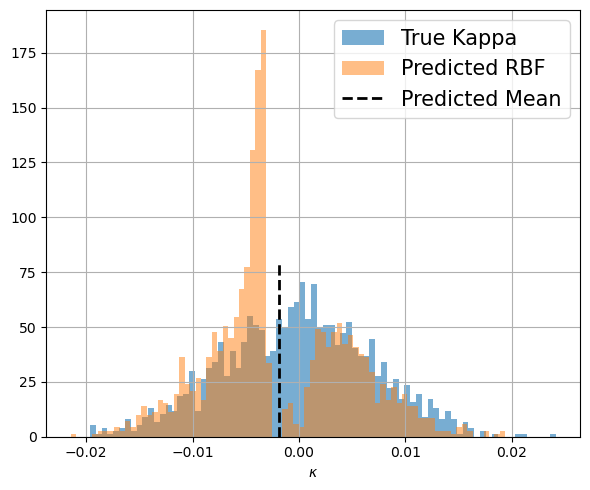

In [ ]:
# ----- Histograms of true vs predicted kappa -----
mean_val, _, _, _ = compute_gaussian_stats(pred_kappa_val)
fig = plt.figure(figsize=(6, 5))
plt.hist(kappa_val_avg_fine, bins=80, density=True, alpha=0.6, label='True Kappa')
plt.hist(pred_kappa_val, bins=80, density=True, alpha=0.5, label='Predicted RBF')
plt.vlines(mean_val, ymin=0, ymax=80, color='black', linestyle='--', label='Predicted Mean', linewidth=2)
plt.xlabel(r'$\kappa$')
plt.legend(fontsize=15)
plt.grid()
plt.tight_layout()
# plt.savefig('images/kappa_hist_rbf.jpg', dpi=300)
plt.show()

1.0
1.0


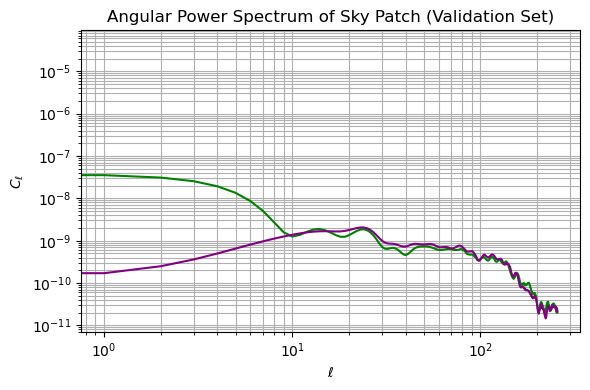

In [64]:
"""
Compute power spectrum on validation set.
Note: Since the sky patch is different from training set, we cannot compare to pseudo Cl here.
"""
full_map_val_rbf = np.zeros(hp.nside2npix(64))
full_map_val_rbf[galaxy_pix1000_unique_val[mask_20k_gals_val]] = pred_kappa_val

mean_subtracted_val = full_map_val_rbf - np.mean(full_map_val_rbf[full_map_val_rbf != 0])   #Remove monopole
cls_raw_val = hp.anafast(mean_subtracted_val, lmax=256)
f_sky_val = np.count_nonzero(mean_subtracted_val) / mean_subtracted_val.size
print(f_sky_val)
cls_corr_val = cls_raw_val / f_sky_val



full_map_perf2 = np.zeros(hp.nside2npix(64))
full_map_perf2[galaxy_pix1000_unique_val[mask_20k_gals_val]] = kappa_val_avg_fine


mean_subtracted_perf2 = full_map_perf2 - np.mean(full_map_perf2[full_map_perf2 != 0])   #Remove monopole
cls_raw_perf2 = hp.anafast(mean_subtracted_perf2, lmax=256)
f_sky_perf2 = np.count_nonzero(mean_subtracted_perf2) / mean_subtracted_perf2.size
print(f_sky_perf2)
cls_corr_perf2 = cls_raw_perf2 / f_sky_perf2




ell = np.arange(len(cls_corr_val))
plt.figure(figsize=(6,4))
plt.plot(cls_corr_val, label='Recovered Power Spectrum: Validation Set RBF', color='green')
# plt.plot(pseudo_cl, label=r'Pseudo Power Spectrum', color='red') 
plt.plot(cls_corr_perf2, label='Recovered Kappa Power Spectrum (Perfect)', color='purple') 
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.title('Angular Power Spectrum of Sky Patch (Validation Set)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.tight_layout()
# plt.legend()
plt.show()